In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from lifetimes import BetaGeoFitter 
from lifetimes.plotting import plot_frequency_recency_matrix

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import umap

c:\Users\bxz19\anaconda3\envs\apostro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
### LOADING DATASETS

# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')
data_dir = working_dir + 'data/'

## Load the dataset
installs_data_dir = data_dir + 'case-study-installs.csv'
transaction_data_dir = data_dir + 'case-study-transactions.csv'

installs_data = pd.read_csv(installs_data_dir)
transaction_data = pd.read_csv(transaction_data_dir)

## Data Formatting and Quality Control

In [3]:
## Converting dates to datetime format to simplify handling and ensure correct formatting
installs_data['install_date'] = pd.to_datetime(installs_data['install_date'])
transaction_data['transaction_date'] = pd.to_datetime(transaction_data['transaction_date'])

In [4]:
## Basic data inspection to detect missing values or errors.

# Checking for missing values in each DataFrame
print("Missing values in Installs Data:")
print(installs_data.isnull().sum())
print("\nMissing values in Transactions Data:")
print(transaction_data.isnull().sum())

# Checking for any data type issues
print("\nData types in Installs Data:")
print(installs_data.dtypes)
print("\nData types in Transactions Data:")
print(transaction_data.dtypes)

# Descriptive statistics (As in R, for general visual check)
print("\nDescriptive Statistics for Transactions Data:")
print(transaction_data.describe())



# Descriptive statistics about payment and free trial
print("\n\nSummary of is_free_trial:")
print(transaction_data['is_free_trial'].value_counts())

print("\nSummary of is_conversion_to_pay:")
print(transaction_data['is_conversion_to_pay'].value_counts())

# Check prices of suscriptions
print("\nPrices of the subscriptions price_in_usd:")
print(transaction_data['price_in_usd'].value_counts())

# Cross-tabulation of the is_free_trial and is_conversion_to_pay columns
cross_tab = pd.crosstab(transaction_data['is_free_trial'], transaction_data['is_conversion_to_pay'])
print("\nCross-tabulation of Free Trial and Conversion to Pay:")
print(cross_tab)

Missing values in Installs Data:
user_id         0
segment         0
install_date    0
dtype: int64

Missing values in Transactions Data:
transaction_date            0
user_id                     0
is_free_trial               0
is_conversion_to_pay        0
price_in_usd            14958
dtype: int64

Data types in Installs Data:
user_id                  int64
segment                  int64
install_date    datetime64[ns]
dtype: object

Data types in Transactions Data:
transaction_date        datetime64[ns]
user_id                          int64
is_free_trial                     bool
is_conversion_to_pay              bool
price_in_usd                   float64
dtype: object

Descriptive Statistics for Transactions Data:
                    transaction_date        user_id  price_in_usd
count                          40819   40819.000000  2.586100e+04
mean   2023-10-09 12:48:42.051005696   75185.633578  2.990000e+00
min              2023-09-01 00:00:00       5.000000  2.990000e+00
25%     

## Data Visualization

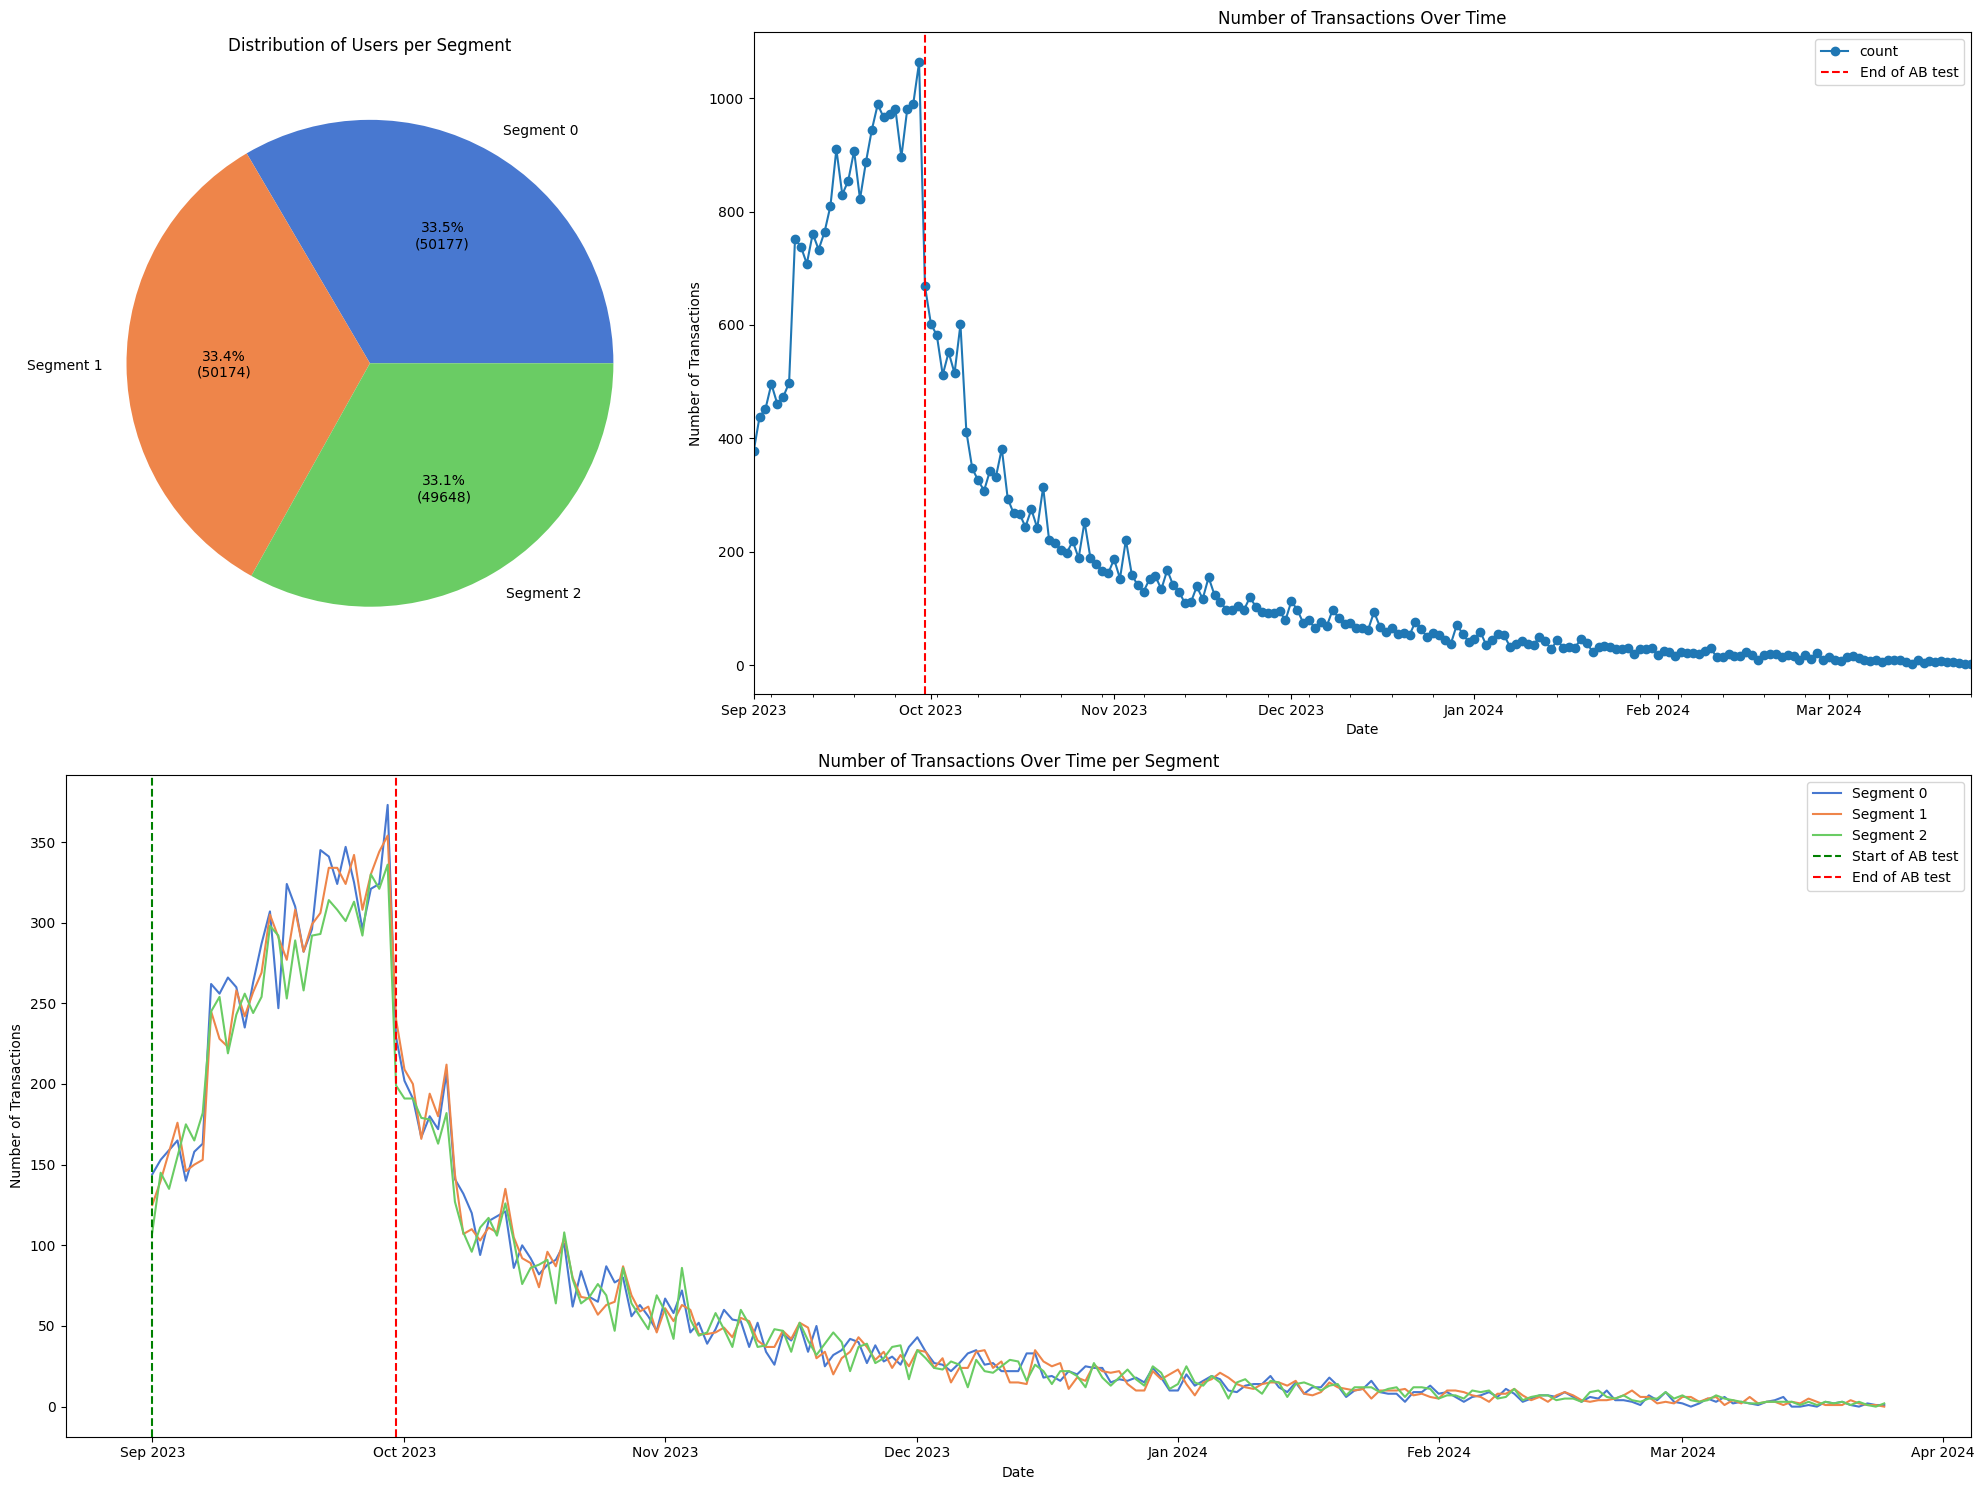

In [5]:
## Data Visualization

# Color palette for the segments, consistent in all plots.
segment_palette = sns.color_palette('muted', len( installs_data['segment'].value_counts()))



# Figure for subplots with basic data visualization 
plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])

# Plotting the distribution of segments as a pie chart
plt.subplot(gs[0])
segment_counts = installs_data['segment'].value_counts()

custom_labels = ['Segment {}'.format(seg) for seg in segment_counts.index]  # Custom Segment labels to make it cute
# We create custom labels for the Segments with a auxfunct, to display number of users and % for each segment
def func(pct, values):
    absolute = int(pct/100.*np.sum(values))
    return "{:.1f}%\n({:d})".format(pct, absolute)
plt.pie(segment_counts, labels=custom_labels, autopct=lambda label: func(label, segment_counts), colors=segment_palette)
plt.title('Distribution of Users per Segment')


# Plotting the number of transactions by date
plt.subplot(gs[1])
transaction_data['transaction_date'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
# Formatting x-axis to display month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# Adding vertical line to display end of AB testing period
plt.axvline(x='2023-09-30', color='red', linestyle='--', label='End of AB test')
plt.legend()



## Data Visualization per segment

# Create a new DataFrame to analyze transactions over time by segment
# Appending the 'segment' id to each transaction 
transactions_df = transaction_data.copy()
transactions_df = transaction_data.merge(installs_data[['user_id', 'segment']], on='user_id', how='left')

transactions_df['count'] = 1
transactions_by_date_segment = transactions_df.groupby(['transaction_date', 'segment']).agg({'count': 'sum'}).unstack(fill_value=0)
transactions_by_date_segment.columns = transactions_by_date_segment.columns.droplevel(0)
transactions_df.drop(columns=['count'], inplace=True)

# Plotting the number of transactions by date for each segment
plt.subplot(gs[2:])
for segment in transactions_by_date_segment.columns:
    plt.plot(transactions_by_date_segment.index, transactions_by_date_segment[segment], label=f'Segment {segment}', color=segment_palette[segment])

plt.title('Number of Transactions Over Time per Segment')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend(title="Segment")

# Formatting x-axis to display month and year, adding a vertical line for AB test period
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.axvline(x=pd.to_datetime('2023-09-01'), color='green', linestyle='--', label='Start of AB test')
plt.axvline(x=pd.to_datetime('2023-09-30'), color='red', linestyle='--', label='End of AB test')
plt.legend()



plt.tight_layout()
plt.show()

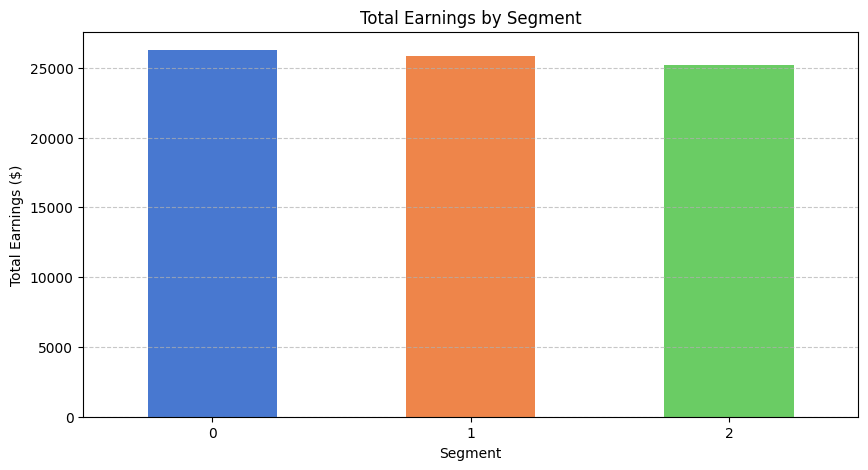

In [6]:
# Calculating total earnings for each segment
earnings_by_segment = transactions_df.groupby('segment')['price_in_usd'].sum()

# Plotting
earnings_by_segment.plot(kind='bar', color=segment_palette, figsize=(10, 5))
plt.title('Total Earnings by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Earnings ($)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Data Exploration

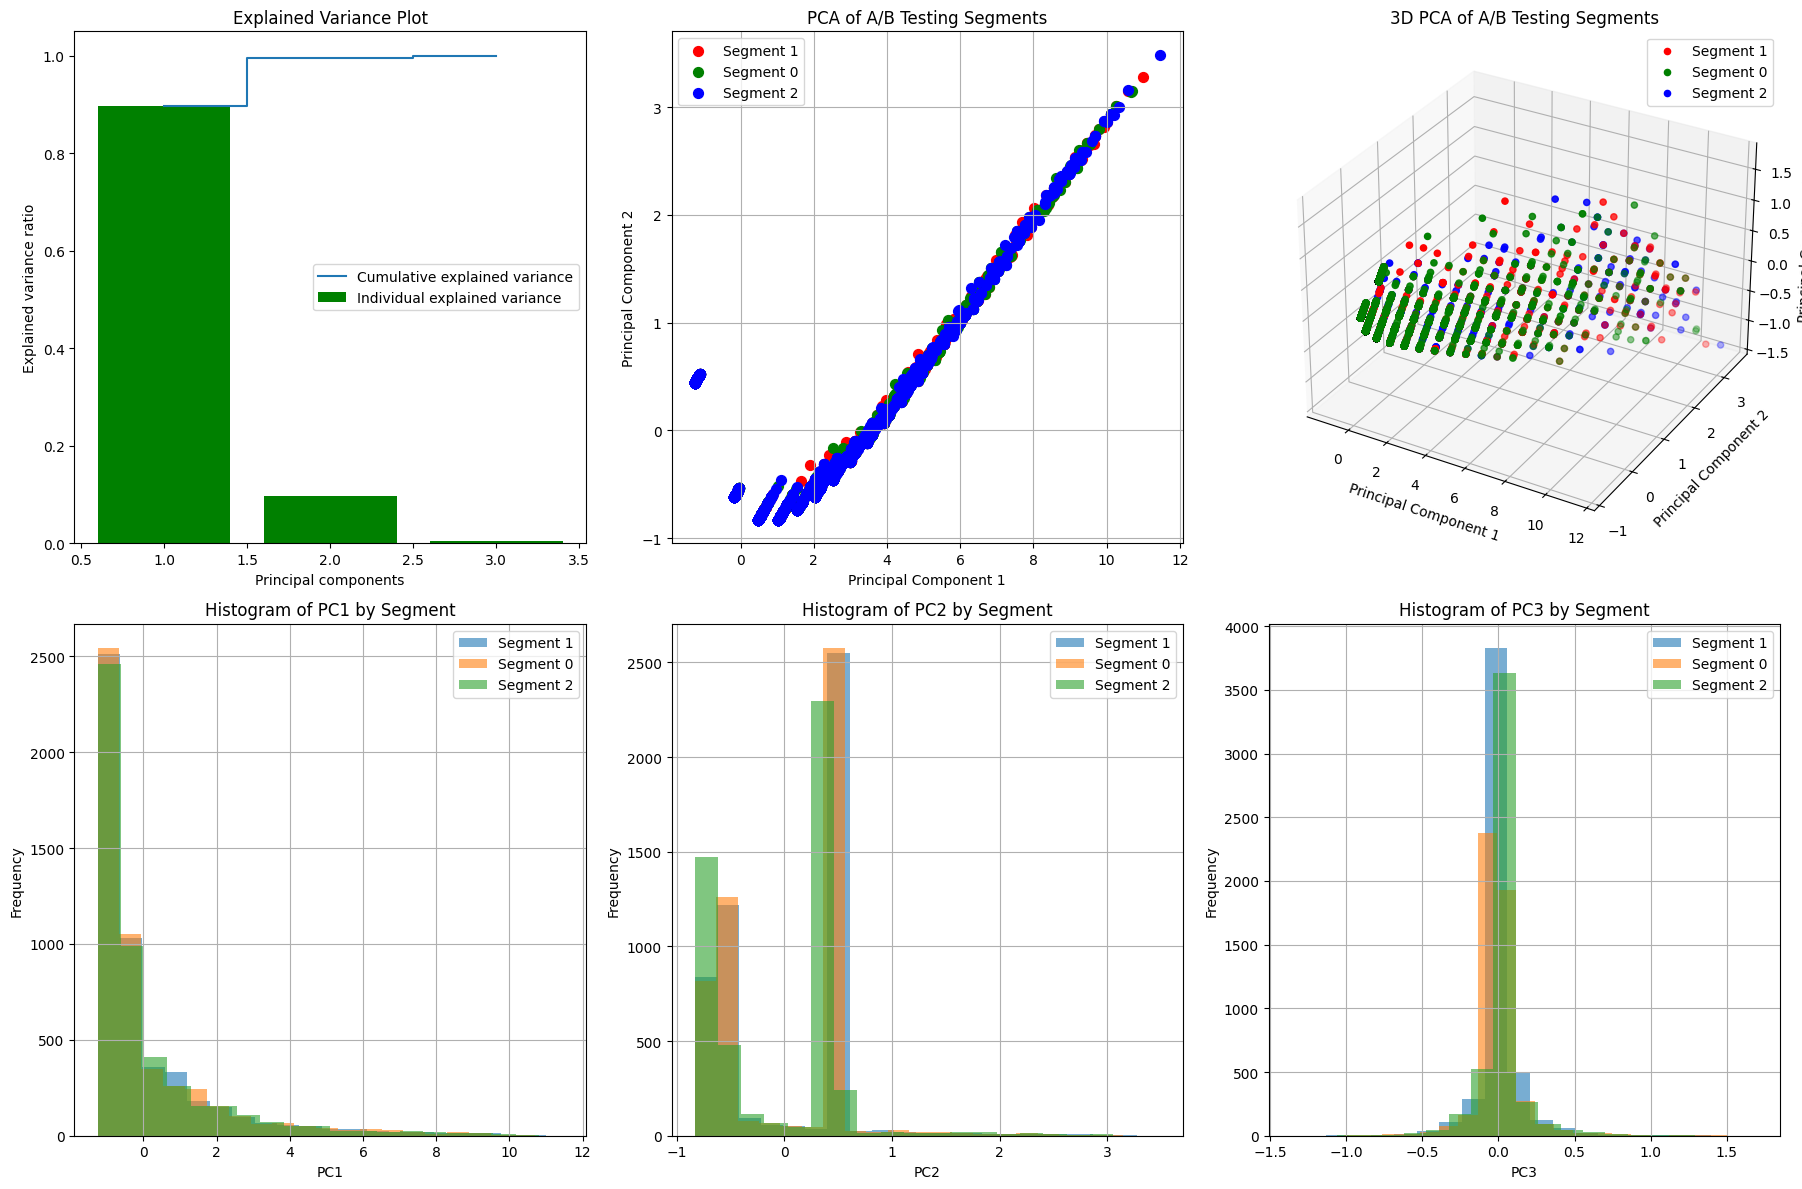

In [7]:
## PCA Analysis

transactions_all_df = transaction_data.merge(installs_data, on='user_id', how='left')
transactions_all_df['price_in_usd'] = transactions_all_df['price_in_usd'].fillna(0 )

# Calculate user metrics
user_metrics = transactions_all_df.groupby('user_id').agg({
    'price_in_usd': ['sum', 'count', 'mean'],
    'transaction_date': 'max'
})
user_metrics.columns = ['total_revenue', 'number_of_transactions', 'average_transaction_value', 'last_transaction_date']
user_metrics['retention_days'] = (user_metrics['last_transaction_date'] - installs_data.set_index('user_id')['install_date']).dt.days
user_metrics.reset_index(inplace=True)
user_metrics = user_metrics.merge(installs_data[['user_id', 'segment']], on='user_id', how='left')

# Preparing the data for PCA
features = ['total_revenue', 'number_of_transactions', 'average_transaction_value', 'retention_days']
x = user_metrics.loc[:, features].values

# Impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
x_imputed = imputer.fit_transform(x)

# Standardize the data
x_standardized = StandardScaler().fit_transform(x_imputed)

# Applying PCA with 3 components
pca_full = PCA(n_components=3)  
principal_components_full = pca_full.fit_transform(x_standardized)
principal_df_full = pd.DataFrame(data=principal_components_full,
                                 columns=['PC1', 'PC2', 'PC3'])
final_df_full = pd.concat([principal_df_full, user_metrics[['segment']]], axis=1)




# Create a large figure to hold all subplots
fig = plt.figure(figsize=(18, 12))

# Subplot 1: Variance Explained Plot
ax1 = fig.add_subplot(2, 3, 1) 
ax1.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_, color='g',
        label='Individual explained variance')
ax1.step(range(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_), where='mid',
         label='Cumulative explained variance')
ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('Principal components')
ax1.legend(loc='best')
ax1.set_title('Explained Variance Plot')

# Subplot 2: 2D Scatter Plot
ax2 = fig.add_subplot(2, 3, 2)
colors = ['r', 'g', 'b']
for segment, color in zip(final_df_full['segment'].unique(), colors):
    indices_to_keep = final_df_full['segment'] == segment
    ax2.scatter(final_df_full.loc[indices_to_keep, 'PC1'],
                final_df_full.loc[indices_to_keep, 'PC2'],
                c=color, s=50, label=f'Segment {segment}')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title('PCA of A/B Testing Segments')

# Subplot 3: 3D Scatter Plot
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
for segment, color in zip(final_df_full['segment'].unique(), colors):
    indices_to_keep = final_df_full['segment'] == segment
    ax3.scatter(final_df_full.loc[indices_to_keep, 'PC1'],
                final_df_full.loc[indices_to_keep, 'PC2'],
                final_df_full.loc[indices_to_keep, 'PC3'],
                c=color, label=f'Segment {segment}')
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_zlabel('Principal Component 3')
ax3.set_title('3D PCA of A/B Testing Segments')
ax3.legend()

# Subplots 4-6: Histograms for each principal component
for i, pc in enumerate(['PC1', 'PC2', 'PC3'], start=4):
    ax = fig.add_subplot(2, 3, i)
    for segment in final_df_full['segment'].unique():
        subset = final_df_full[final_df_full['segment'] == segment]
        ax.hist(subset[pc], bins=20, alpha=0.6, label=f'Segment {segment}')
    ax.set_title(f'Histogram of {pc} by Segment')
    ax.set_xlabel(pc)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

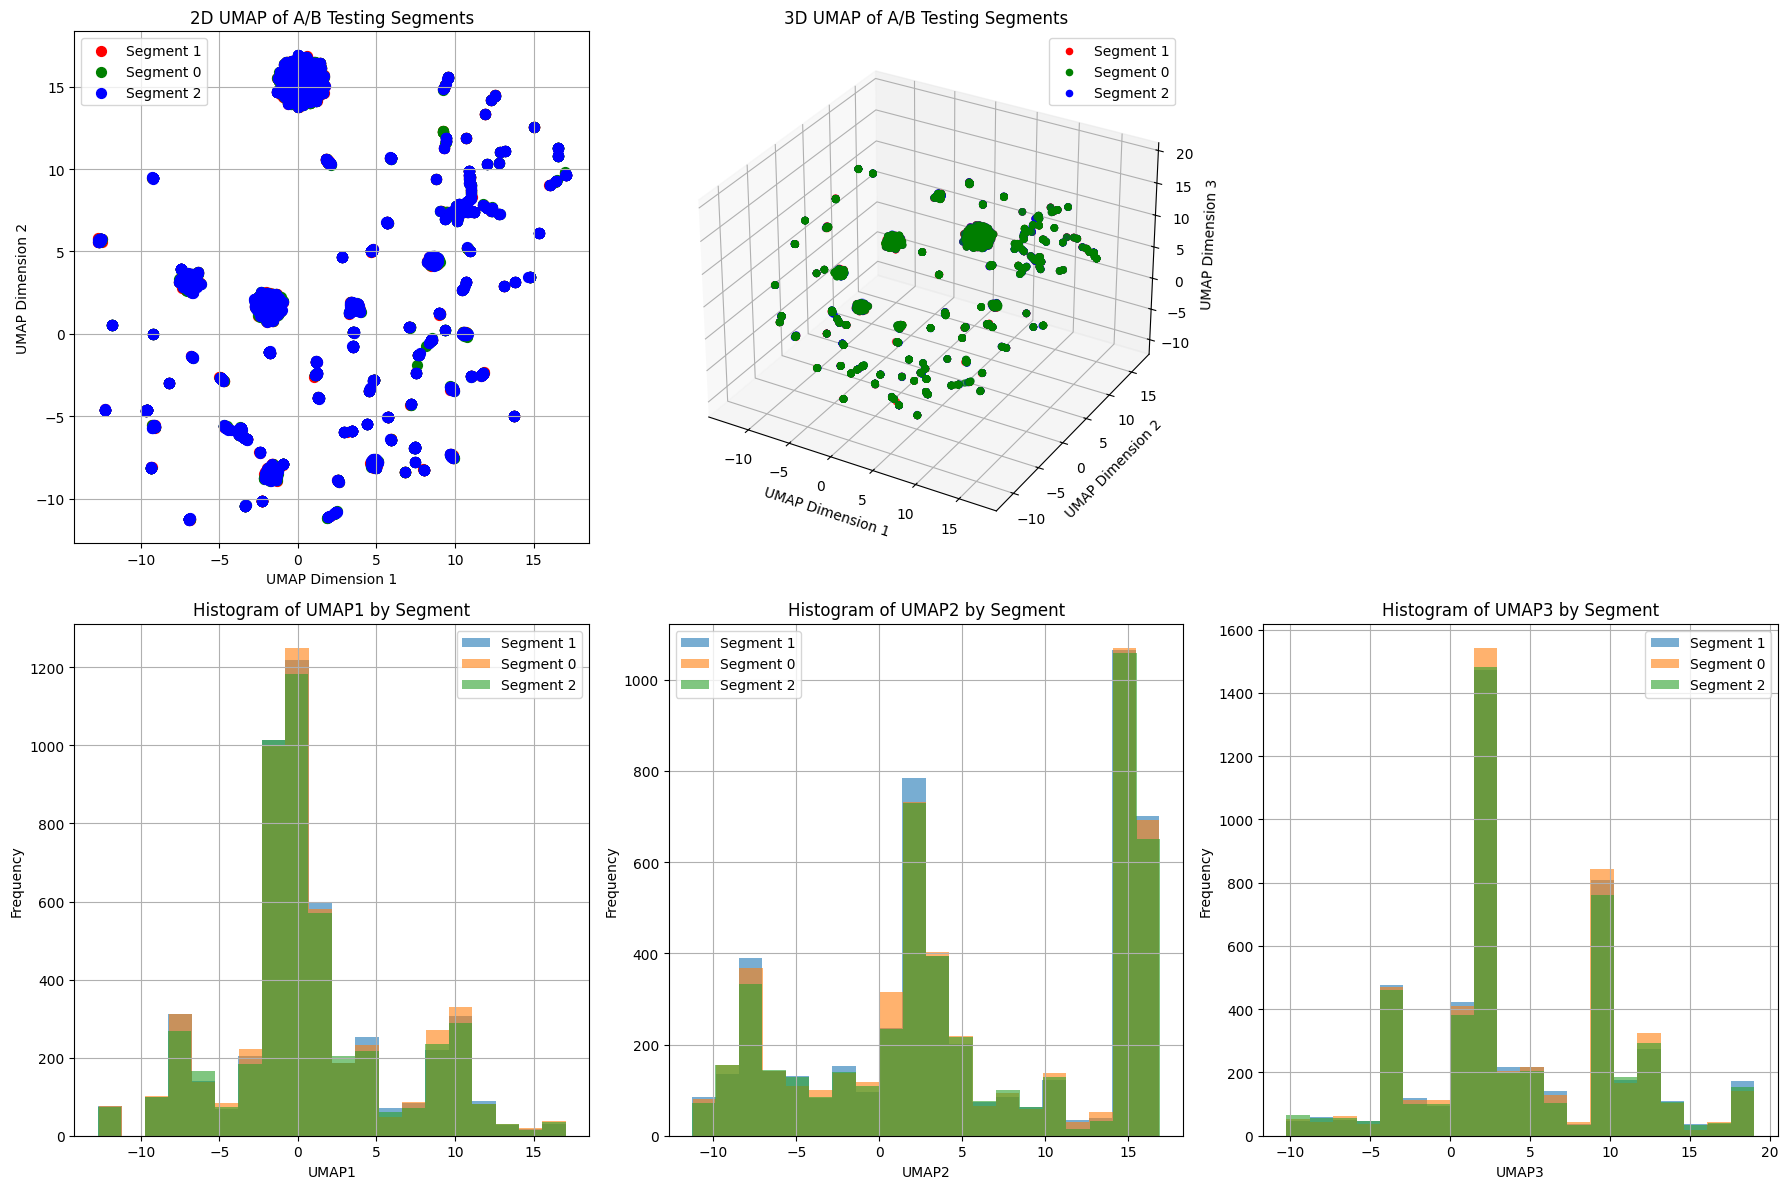

In [8]:
## UMAP (Uniform Manifold Approximation and Projection) 

# Applying UMAP
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = reducer.fit_transform(x_standardized)
embedding_df = pd.DataFrame(data=embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
final_umap_df = pd.concat([embedding_df, user_metrics[['segment']]], axis=1)

# Create a large figure to hold all plots
fig = plt.figure(figsize=(18, 12))

# 2D UMAP Plot
ax1 = fig.add_subplot(2, 3, 1)
colors = ['r', 'g', 'b']
for segment, color in zip(final_umap_df['segment'].unique(), colors):
    indices_to_keep = final_umap_df['segment'] == segment
    ax1.scatter(final_umap_df.loc[indices_to_keep, 'UMAP1'],
                final_umap_df.loc[indices_to_keep, 'UMAP2'],
                c=color, s=50, label=f'Segment {segment}')
ax1.legend()
ax1.grid()
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('2D UMAP of A/B Testing Segments')

# 3D UMAP Plot
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
for segment, color in zip(final_umap_df['segment'].unique(), colors):
    indices_to_keep = final_umap_df['segment'] == segment
    ax2.scatter(final_umap_df.loc[indices_to_keep, 'UMAP1'],
                final_umap_df.loc[indices_to_keep, 'UMAP2'],
                final_umap_df.loc[indices_to_keep, 'UMAP3'],
                c=color, label=f'Segment {segment}')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
ax2.set_zlabel('UMAP Dimension 3')
ax2.set_title('3D UMAP of A/B Testing Segments')
ax2.legend()

# Histograms for UMAP dimensions
for i, umap_dim in enumerate(['UMAP1', 'UMAP2', 'UMAP3'], start=4):
    ax = fig.add_subplot(2, 3, i)
    for segment in final_umap_df['segment'].unique():
        subset = final_umap_df[final_umap_df['segment'] == segment]
        ax.hist(subset[umap_dim], bins=20, alpha=0.6, label=f'Segment {segment}')
    ax.set_title(f'Histogram of {umap_dim} by Segment')
    ax.set_xlabel(umap_dim)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show


## User Metrics 

In [9]:
## User Retention
"""
Retention Rate measures the proportion of users who continue to engage with the business
over a period of time, typically measured by the number of users with more than one transaction.
"""

# Retention Rate per Segment
user_transactions = transactions_df.groupby(['user_id', 'segment']).size().reset_index().groupby('segment').size()
total_users_per_segment = installs_data.groupby('segment').size()
retention_rate_by_segment = (user_transactions / total_users_per_segment)


print("Retention Rates by Segment.")
for segment, retention_rate in retention_rate_by_segment.items():
    print(f"Segment {segment}: {(retention_rate*100):.3f}%")

Retention Rates by Segment.
Segment 0: 10.120%
Segment 1: 9.997%
Segment 2: 9.797%


In [10]:
## User Conversion Rates 
"""
Conversion Rate measures the proportion of users who take a desired action, in this case,
renovating their subscription after the free trial. It indicates the effectiveness of 
converting trial users into paying customers, a crucial aspect for business growth.

The calculation involves dividing the number of users who converted (had a transaction 
after the free trial) by the total number of users who used the free trial.
"""

free_trial_users = transactions_df[(transactions_df['is_free_trial'] == True)]
payed_users = transactions_df[(transactions_df['is_free_trial'] == False) & (transactions_df['is_conversion_to_pay'] == True)]

free_trial_user_ids = set(free_trial_users['user_id'])
payed_user_ids = set(payed_users['user_id'])

converted_user_ids = free_trial_user_ids.intersection(payed_user_ids)

transactions_df['converted_from_free_trial'] = transactions_df['user_id'].apply(lambda x: x in converted_user_ids)
conversion_rate_by_segment = transactions_df.groupby('segment')['converted_from_free_trial'].mean()

print("Conversion Rates by Segment.")
for segment, conversion_rate in conversion_rate_by_segment.items():
    print(f"Segment {segment}: {(conversion_rate*100):.3f}%")

Conversion Rates by Segment.
Segment 0: 81.663%
Segment 1: 81.619%
Segment 2: 81.482%


In [11]:
## Average Revenue Per User (ARPU)
"""
Average Revenue Per User (ARPU) is a key metric that indicates the average revenue generated
per user within a specific segment. It helps evaluate the revenue-generating efficiency of
each segment and assess the effectiveness of marketing and monetization strategies.

ARPU is calculated by dividing the total revenue generated within a segment by the total
number of users in that segment.
"""

# Find the duration of the data
start_date = transactions_df['transaction_date'].min()
end_date = transactions_df['transaction_date'].max()
months_of_data = pd.period_range(start=start_date, end=end_date, freq='M')

revenue_by_segment = transactions_df.groupby('segment')['price_in_usd'].sum()
users_per_segment = installs_data.groupby('segment').size()

# ARPU calculation
arpu_by_segment = revenue_by_segment / users_per_segment / len(months_of_data) * 6

print("ARPU by Segment.")
for segment, arpu in arpu_by_segment.items():
    print(f"Segment {segment}: {arpu:.3f} usd")

ARPU by Segment.
Segment 0: 0.449 usd
Segment 1: 0.442 usd
Segment 2: 0.435 usd


In [12]:
## User Lifetime Value (LTV) using BG/BB Model
"""
User Lifetime Value (LTV) is a metric that estimates the total revenue a customer
is expected to generate throughout their relationship with the business. It helps in 
assessing the long-term profitability of different customer segments and guiding 
marketing and retention strategies.

In this code:
- Frequency and recency data are prepared for each user and segment.
- The BetaGeoFitter model from the lifetimes library is fitted for each user to 
  estimate future purchases using the BG/BB model.
- LTV is calculated for each segment based on the expected number of future purchases 
  and the average price per transaction.
- Finally, the predicted LTV for each segment is printed.
"""

# Preparing frequency and recency data
summary = transactions_df.groupby(['user_id', 'segment']).agg({
    'transaction_date': ['min', 'max', 'count'],
})
summary.columns = ['first_date', 'last_date', 'frequency']
summary['recency'] = (summary['last_date'] - summary['first_date']).dt.days
summary['users_usage_life'] = (transactions_df['transaction_date'].max() - summary['first_date']).dt.days
# Filter out users with only 1 purchase
summary = summary[summary['frequency'] > 1]  


# Fit the BG/BB model for each segment, and calculate the LTV for each user on each segment
ltv_per_user_per_segment = {}
for segment in summary.index.get_level_values('segment').unique():
    segment_data = summary.xs(segment, level='segment')
    bgbb_fitter = BetaGeoFitter(penalizer_coef=0.1)
    bgbb_fitter.fit(segment_data['frequency'], segment_data['recency'], segment_data['users_usage_life'])
    for user_id, row in segment_data.iterrows():
        estimated_purchases = bgbb_fitter.conditional_expected_number_of_purchases_up_to_time(
                                        365, row['frequency'], row['recency'], row['users_usage_life'])
        average_price = 2.99  # Price of the unique subscription, as observed in previous analysis
        ltv_per_user_per_segment[(user_id, segment)] = estimated_purchases * average_price


# Create DataFrame for LTV values
ltv_df = pd.DataFrame([
    {'user_id': user_id, 'segment': segment, 'ltv': ltv}
    for (user_id, segment), ltv in ltv_per_user_per_segment.items()
])
ltv_df.set_index(['user_id', 'segment'], inplace=True)
summary = summary.join(ltv_df['ltv'])

# Calculate average LTV per segment
segment_ltv = {}

for (user_id, segment), ltv in ltv_per_user_per_segment.items():
    if segment in segment_ltv:
        segment_ltv[segment].append(ltv)
    else:
        segment_ltv[segment] = [ltv]

# Calculate the average LTV for each segment
ltv_by_segment = {segment: np.mean(ltvs) for segment, ltvs in segment_ltv.items()}

print("Average Predicted LTV by Segment:")
for segment, ltv in ltv_by_segment.items():
    print(f"Segment {segment}: {ltv:.3f} usd")

Average Predicted LTV by Segment:
Segment 0: 1.256 usd
Segment 1: 1.388 usd
Segment 2: 1.601 usd


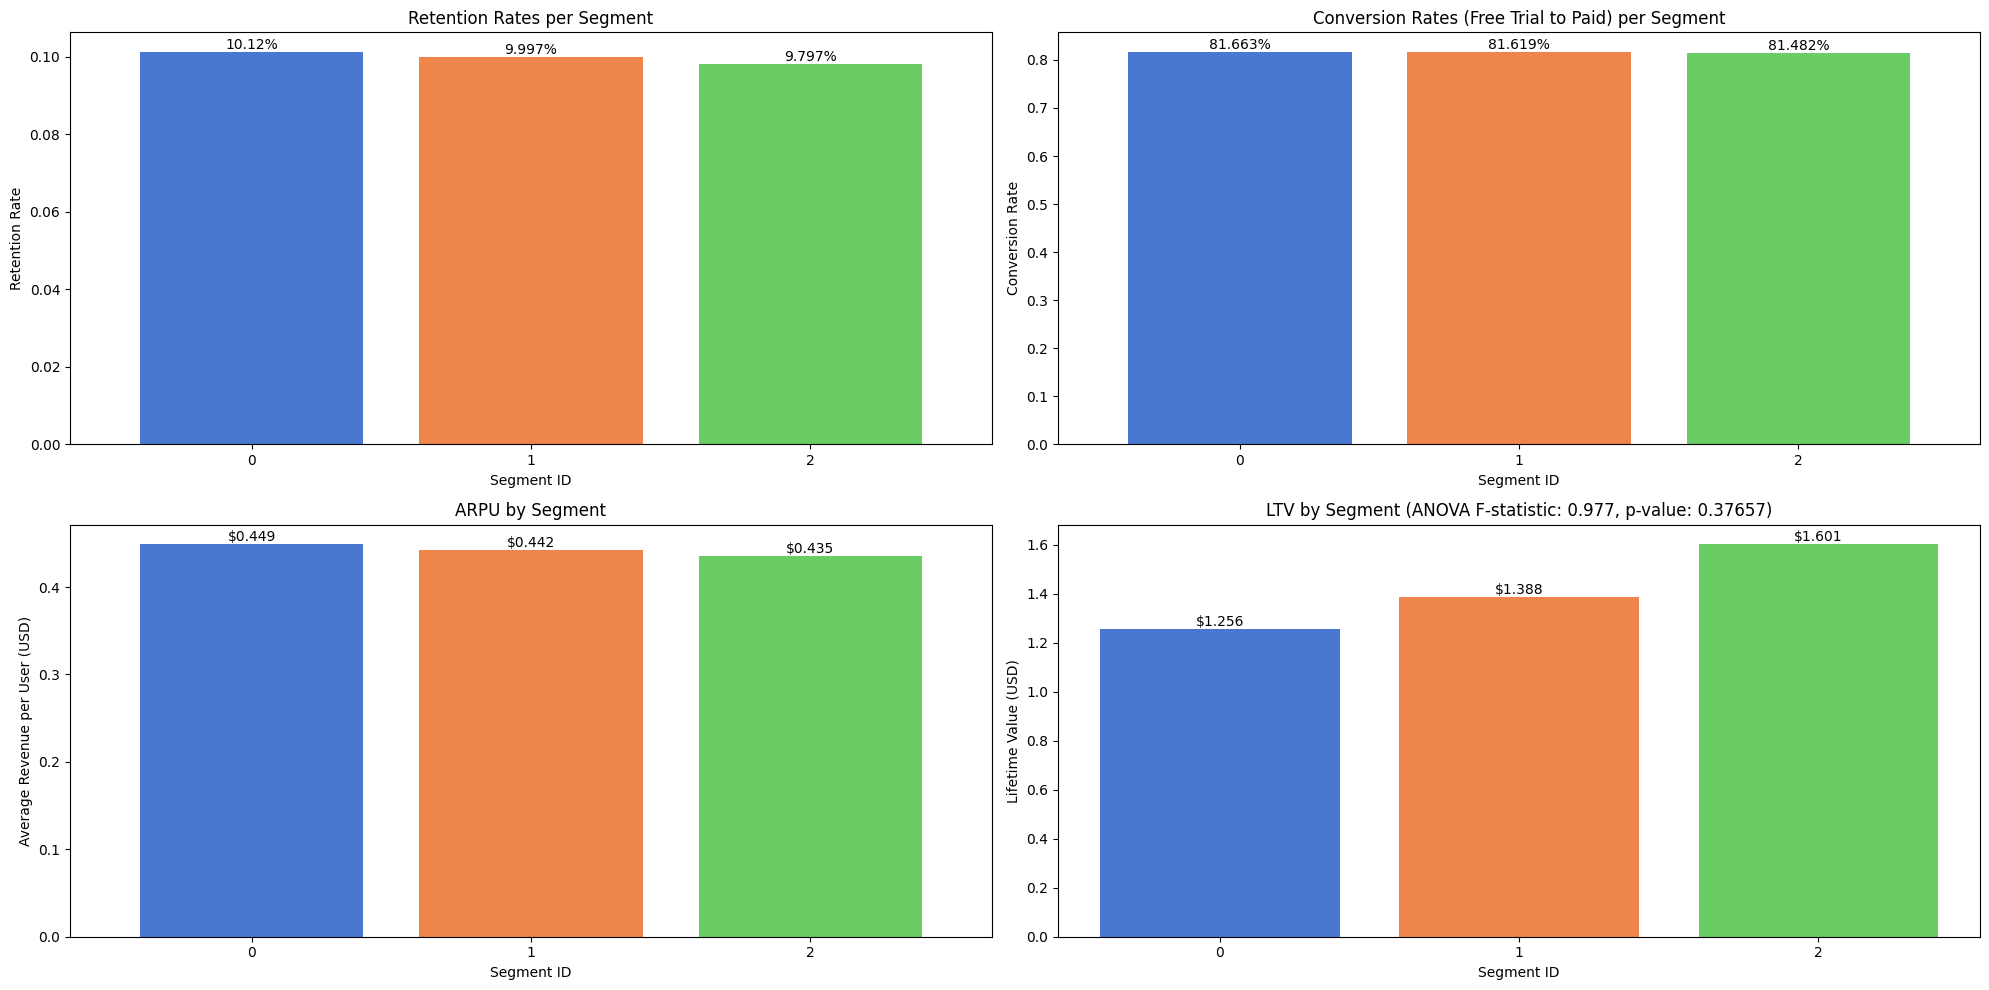

In [13]:
## Visualize all metrics.
plt.figure(figsize=(20, 10))


# Plotting Retention Rates
plt.subplot(2, 2, 1)
retention_rate_plot = retention_rate_by_segment.plot(kind='bar', color=segment_palette, rot=0, width=0.8)
plt.title(f'Retention Rates per Segment')
plt.xlabel('Segment ID')
plt.ylabel('Retention Rate')
for i, bar in enumerate(retention_rate_plot.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), \
             f'{round(bar.get_height()*100, 3)}%', \
             ha='center', va='bottom')


# Plotting Conversion Rates
plt.subplot(2, 2, 2)
conversion_rate_plot = conversion_rate_by_segment.plot(kind='bar', color=segment_palette, rot=0, width=0.8)
plt.title(f'Conversion Rates (Free Trial to Paid) per Segment')
plt.xlabel('Segment ID')
plt.ylabel('Conversion Rate')
for i, bar in enumerate(conversion_rate_plot.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), \
             f'{round(bar.get_height()*100, 3)}%', \
             ha='center', va='bottom')



# Plotting Average Revenue Per User (ARPU) 
plt.subplot(2, 2, 3)
arpu_plot = arpu_by_segment.plot(kind='bar', color=segment_palette, rot=0, width=0.8)
plt.title(f'ARPU by Segment')
plt.xlabel('Segment ID')
plt.ylabel('Average Revenue per User (USD)')
for i, bar in enumerate(arpu_plot.patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), \
             f'${bar.get_height():.3f}', ha='center', va='bottom')


# LTV ANOVA
ltv_groups = [values for values in segment_ltv.values()]
anova_result = f_oneway(*ltv_groups)

# Plotting User Lifetime Value (LTV) using BG/BB Model
plt.subplot(2, 2, 4)
ltv_keys = list(ltv_by_segment.keys())
ltv_values = list(ltv_by_segment.values())
ltv_plot = plt.bar(ltv_keys, ltv_values, color=segment_palette, tick_label=ltv_keys, width=0.8)
plt.title(f'LTV by Segment (ANOVA F-statistic: {anova_result.statistic:.3f}, p-value: {anova_result.pvalue:.5f})')
plt.xlabel('Segment ID')
plt.ylabel('Lifetime Value (USD)')
for bar in ltv_plot:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), \
             f'${bar.get_height():.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



summary.reset_index(inplace=True)

In [14]:
## Other metrics


## Time to First Purchase

# Filter transactions to consider only purchases 
purchases_data = transaction_data[transaction_data['is_free_trial'] == False]

# Find the first purchase date for each user
first_purchase_dates = purchases_data.groupby('user_id')['transaction_date'].min().reset_index()
first_purchase_dates.rename(columns={'transaction_date': 'first_purchase_date'}, inplace=True)
merged_data = pd.merge(first_purchase_dates, installs_data, on='user_id')

# Calculate time to first purchase in days
merged_data['time_to_first_purchase'] = (merged_data['first_purchase_date'] - merged_data['install_date']).dt.days
time_to_first_purchase_by_segment = merged_data.groupby('segment')['time_to_first_purchase'].mean()

# Print results
print("Average Time to First Purchase by Segment:")
print(time_to_first_purchase_by_segment)

Average Time to First Purchase by Segment:
segment
0    7.613565
1    7.610623
2    7.628797
Name: time_to_first_purchase, dtype: float64


In [15]:
## Purchase Frequency
# Calculate total transactions per user
transactions_per_user = transactions_df.groupby(['user_id', 'segment']).size().reset_index(name='transaction_count')

# Calculate average number of transactions per user in each segment
purchase_frequency_by_segment = transactions_per_user.groupby('segment')['transaction_count'].mean()

# Print results
print("Average Purchase Frequency by Segment:")
print(purchase_frequency_by_segment)

Average Purchase Frequency by Segment:
segment
0    2.730012
1    2.724482
2    2.732319
Name: transaction_count, dtype: float64


## Hypothesis Verification, and Effect Study

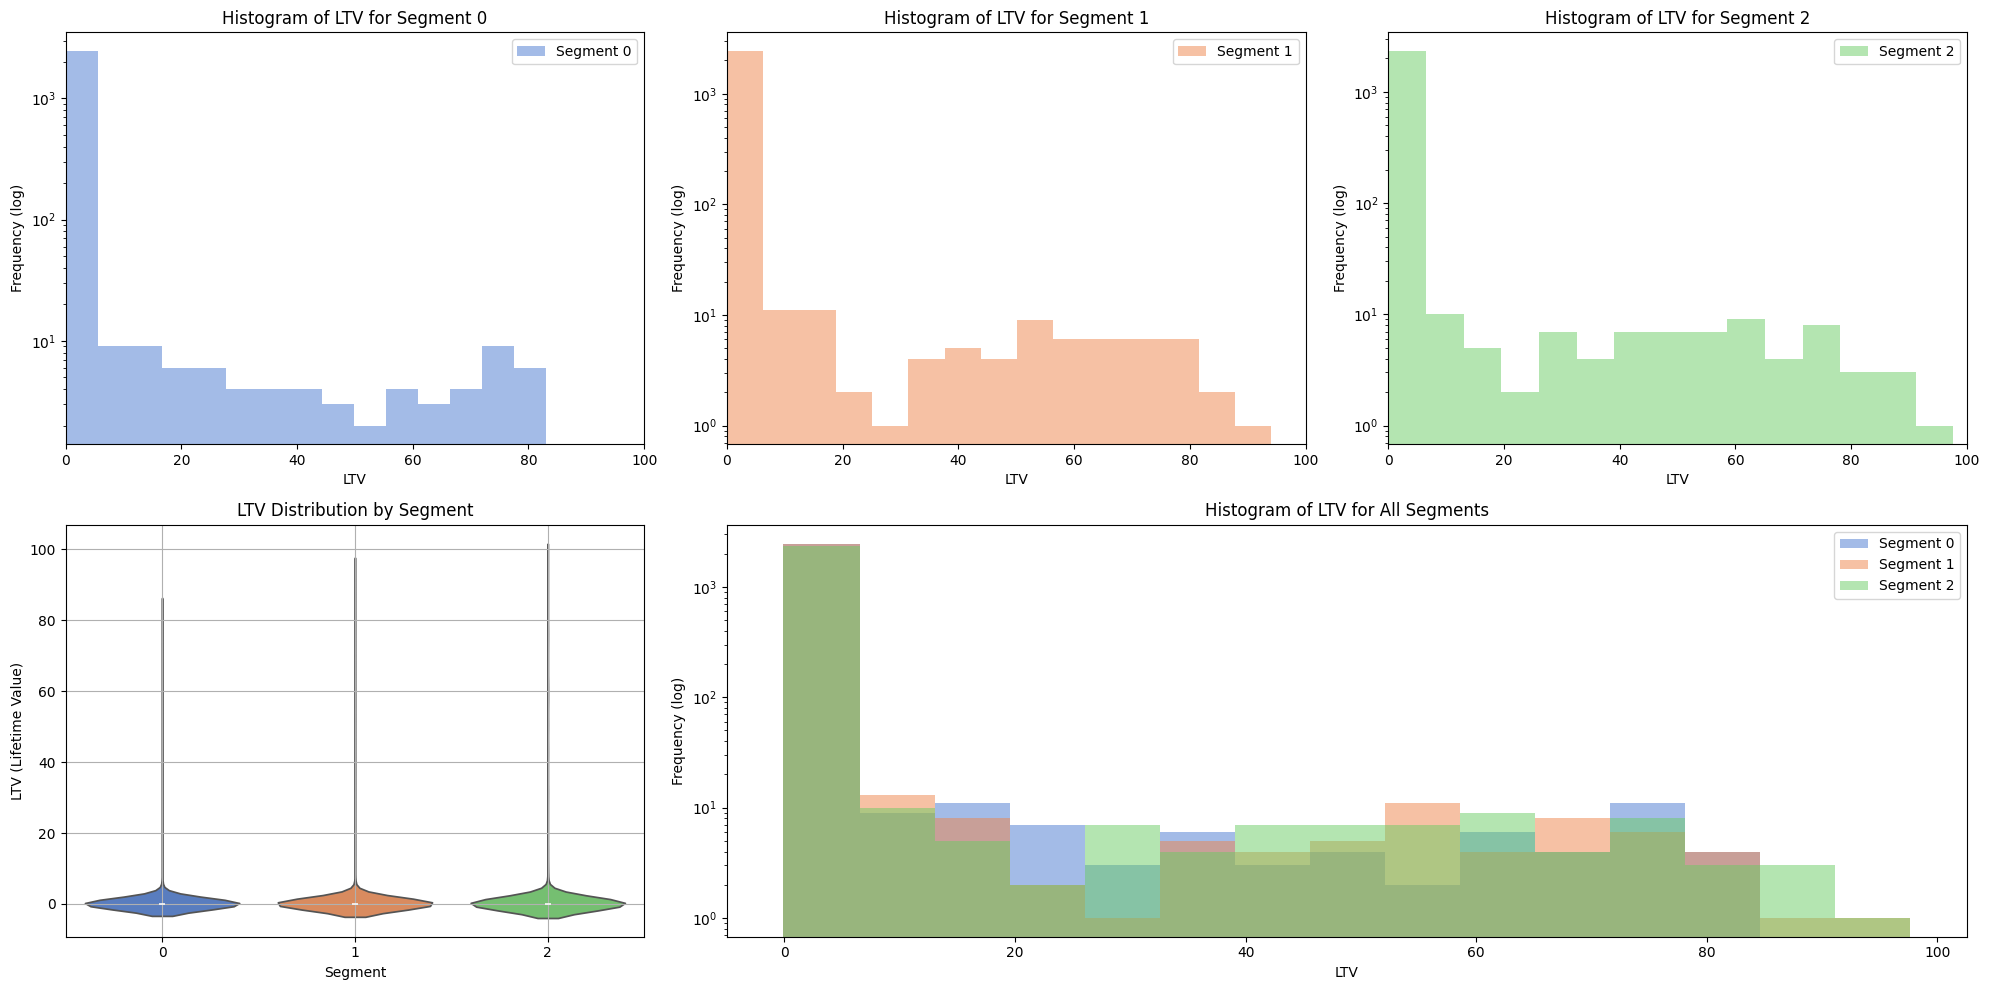

In [16]:
# Hitogram representation of LTV across segments

# Number of bins
N = 15


# Create figure and grid specification
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3)

# Top row for segment histograms
axes_histogram = []
for i in range(3):
    axes_histogram.append(plt.subplot(gs[0, i]))

# Bottom row for violin plot and combined histogram
ax_violin = plt.subplot(gs[1, 0])  
ax_all_segments = plt.subplot(gs[1, 1:3]) 


# Plot histograms for each segment in the top row
for i, segment in enumerate(summary['segment'].unique()):
    ax = axes_histogram[i]
    segment_data = summary[summary['segment'] == segment]['ltv']
    bins = pd.cut(segment_data, bins=N, retbins=True)[1]
    ax.hist(segment_data, bins=bins, alpha=0.5, label=f'Segment {segment}', color=segment_palette[segment])
    ax.set_title(f'Histogram of LTV for Segment {segment}')
    ax.set_xlabel('LTV')
    ax.set_ylabel('Frequency (log)')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlim(xmin=0, xmax = 100)



# Generate violin plot in the bottom left subplot
sns.violinplot(x='segment', y='ltv', data=summary, palette=segment_palette, ax=ax_violin)
ax_violin.set_title('LTV Distribution by Segment')
ax_violin.set_xlabel('Segment')
ax_violin.set_ylabel('LTV (Lifetime Value)')
ax_violin.grid(True)



# Create bins for all LTV data across segments for consistency
all_segment_data = summary['ltv']
bins_all_segments = pd.cut(all_segment_data, bins=N, retbins=True)[1]

# Generate histogram for each segment in the bottom right subplot
for segment in summary['segment'].unique():
    segment_data = summary[summary['segment'] == segment]['ltv']
    ax_all_segments.hist(segment_data, bins=bins_all_segments, alpha=0.5, color=segment_palette[segment], label=f'Segment {segment}')
ax_all_segments.set_title('Histogram of LTV for All Segments')
ax_all_segments.set_xlabel('LTV')
ax_all_segments.set_ylabel('Frequency (log)')
ax_all_segments.set_yscale('log')
ax_all_segments.legend() 

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


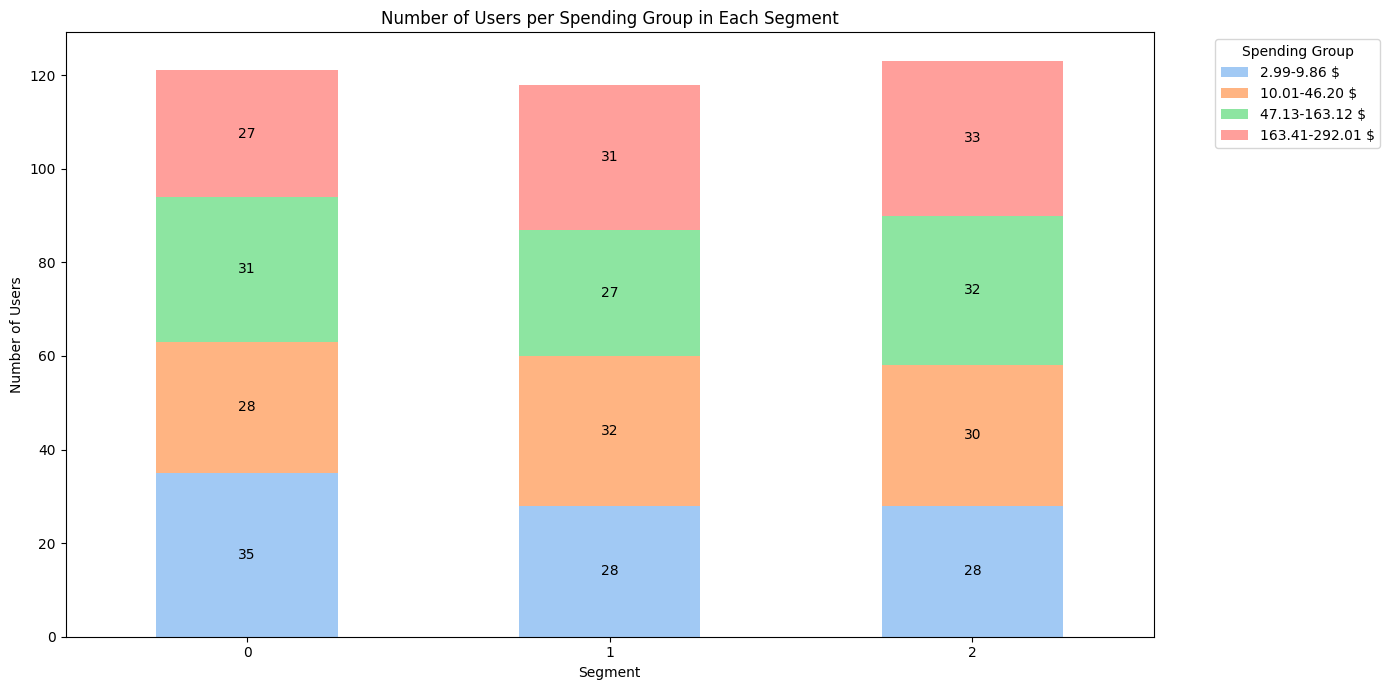

In [17]:
## Stacked Bar Chart for each segment, displaying the ammount of users in each spending bracket

metric_palette = sns.color_palette('pastel', 10)

summary['ltv_spending'] = summary['ltv'] * 2.99
summary_spending_users = summary[summary['ltv_spending'] > 2.99]

# Divide into 4 groups by percentile
summary_spending_users['spending_group'] = pd.qcut(summary_spending_users['ltv_spending'], 4, labels=False)
group_range = summary_spending_users.groupby('spending_group')['ltv_spending'].agg([min, max])

# Label groups with min and max spending
group_labels = ['{:.2f}-{:.2f} $'.format(row['min'], row['max']) for i, row in group_range.iterrows()]
summary_spending_users['spending_group'] = pd.Categorical(summary_spending_users['spending_group'], categories=range(4), ordered=True)
group_counts = summary_spending_users.groupby(['segment', 'spending_group']).size().unstack(fill_value=0)
group_counts.columns = group_labels


# Plotting a stacked bar chart
ax = group_counts.plot(kind='bar', stacked=True, figsize=(14, 7), color=metric_palette)

# Annotate each block with the number of users
for segment_index, segment in enumerate(group_counts.index):
    for group_index, col_name in enumerate(group_counts.columns):
        col_values = group_counts.loc[segment, col_name]
        ax.annotate(col_values, 
                    xy=(segment_index, group_counts.iloc[segment_index, :group_index].sum() + col_values / 2), 
                    ha='center', va='center')

plt.title('Number of Users per Spending Group in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Users')
plt.xticks(range(len(group_counts.index)), group_counts.index, rotation=0)
plt.legend(title='Spending Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
## Random Forest classifier


## Prepare the data to include all Users that have done a transaction, and include LTV data for those with more than 2 transactions.
# Preparing frequency and recency data for all users with transactions
all_users = transactions_df.groupby(['user_id', 'segment']).agg({
    'transaction_date': ['min', 'max', 'count'],
})
all_users.columns = ['first_date', 'last_date', 'frequency']
all_users['recency'] = (all_users['last_date'] - all_users['first_date']).dt.days
all_users['users_usage_life'] = (transactions_df['transaction_date'].max() - all_users['first_date']).dt.days
# Merge with extended LTV data for some
all_data_rf = pd.merge(all_users, summary, on=['user_id', 'segment', 'first_date', 'last_date', 'frequency', 'recency', 'users_usage_life'], how='outer')

# Features and target for the model
features = all_data_rf[['frequency', 'recency', 'users_usage_life', 'ltv_spending']]
target = all_data_rf['segment']
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)


X_train, X_test, y_train, y_test = train_test_split(features_scaled_df, target, test_size=0.2, random_state=25)


# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500, random_state=25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importance analysis
importances = pd.DataFrame({'feature': features.columns, 'importance': np.round(rf.feature_importances_, 4)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
print(importances)

# Data for plots
feature_importances_all = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
conf_matrix_all = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.54      0.61      0.57      1040
           1       0.56      0.54      0.55       949
           2       0.58      0.52      0.55      1003

    accuracy                           0.56      2992
   macro avg       0.56      0.56      0.56      2992
weighted avg       0.56      0.56      0.56      2992

Accuracy: 0.5581550802139037
                  importance
feature                     
ltv_spending          0.7175
users_usage_life      0.1676
recency               0.0578
frequency             0.0571


In [19]:
## Random Forest classifier


## Prepare the data to include ONLY USERS with more than 1 transactions.
features = summary[['frequency', 'recency', 'users_usage_life', 'ltv_spending']]
target = summary['segment']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

X_train, X_test, y_train, y_test = train_test_split(features_scaled_df, target, test_size=0.2, random_state=25)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500, random_state=25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importance analysis
importances = pd.DataFrame({'feature': features.columns, 'importance': np.round(rf.feature_importances_, 4)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
print(importances)


# Data for plots
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
conf_matrix = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.82      0.79      0.81       519
           1       0.80      0.82      0.81       505
           2       0.82      0.84      0.83       465

    accuracy                           0.82      1489
   macro avg       0.82      0.82      0.82      1489
weighted avg       0.82      0.82      0.82      1489

Accuracy: 0.816655473472129
                  importance
feature                     
ltv_spending          0.7230
users_usage_life      0.1626
recency               0.0577
frequency             0.0567


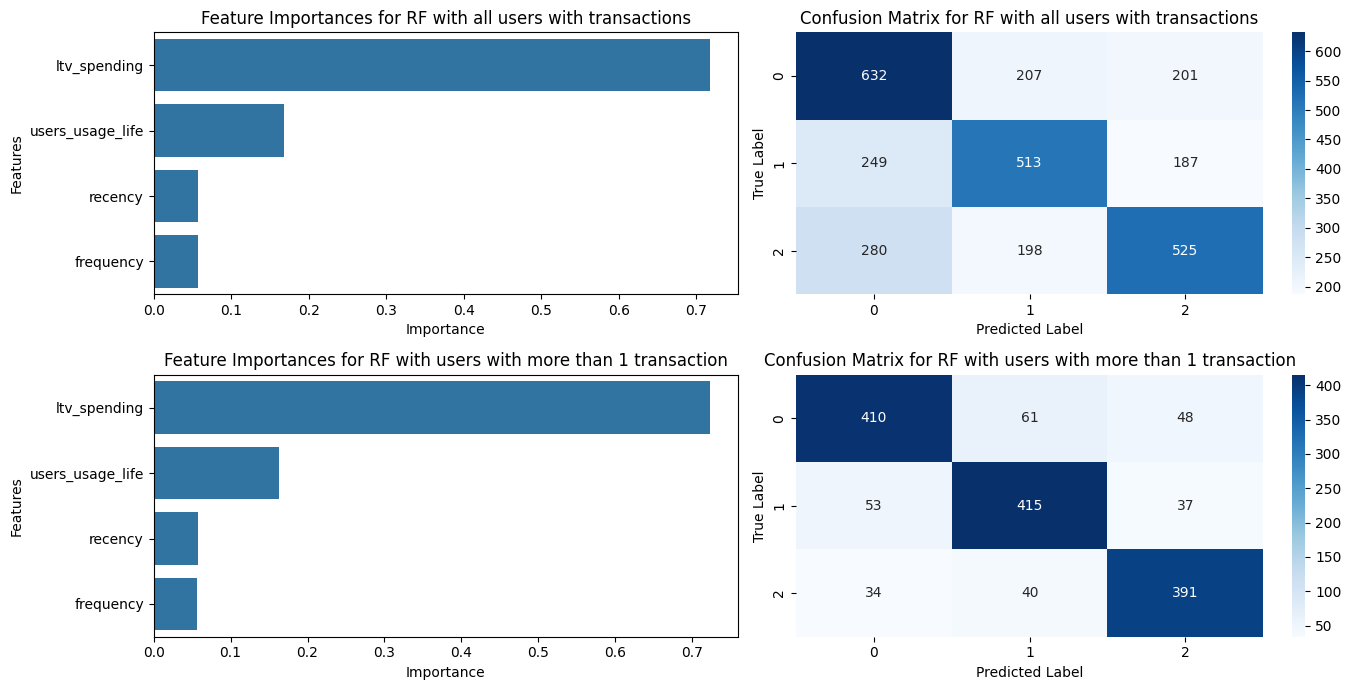

In [20]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 7))

# Plotting feature importances for RF with all users with transactions
sns.barplot(ax=axes[0, 0], x=feature_importances_all.importance, y=feature_importances_all.index)
axes[0, 0].set_title('Feature Importances for RF with all users with transactions')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_ylabel('Features')

# Confusion Matrix for RF with all users with transactions
sns.heatmap(ax=axes[0, 1], data=conf_matrix_all, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
axes[0, 1].set_title('Confusion Matrix for RF with all users with transactions')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Plotting feature importances for RF with users with more than 1 transaction
sns.barplot(ax=axes[1, 0], x=feature_importances.importance, y=feature_importances.index)
axes[1, 0].set_title('Feature Importances for RF with users with more than 1 transaction')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_ylabel('Features')

# Confusion Matrix for RF with users with more than 1 transaction
sns.heatmap(ax=axes[1, 1], data=conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
axes[1, 1].set_title('Confusion Matrix for RF with users with more than 1 transaction')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

# Adjust layout
plt.tight_layout()
plt.show()

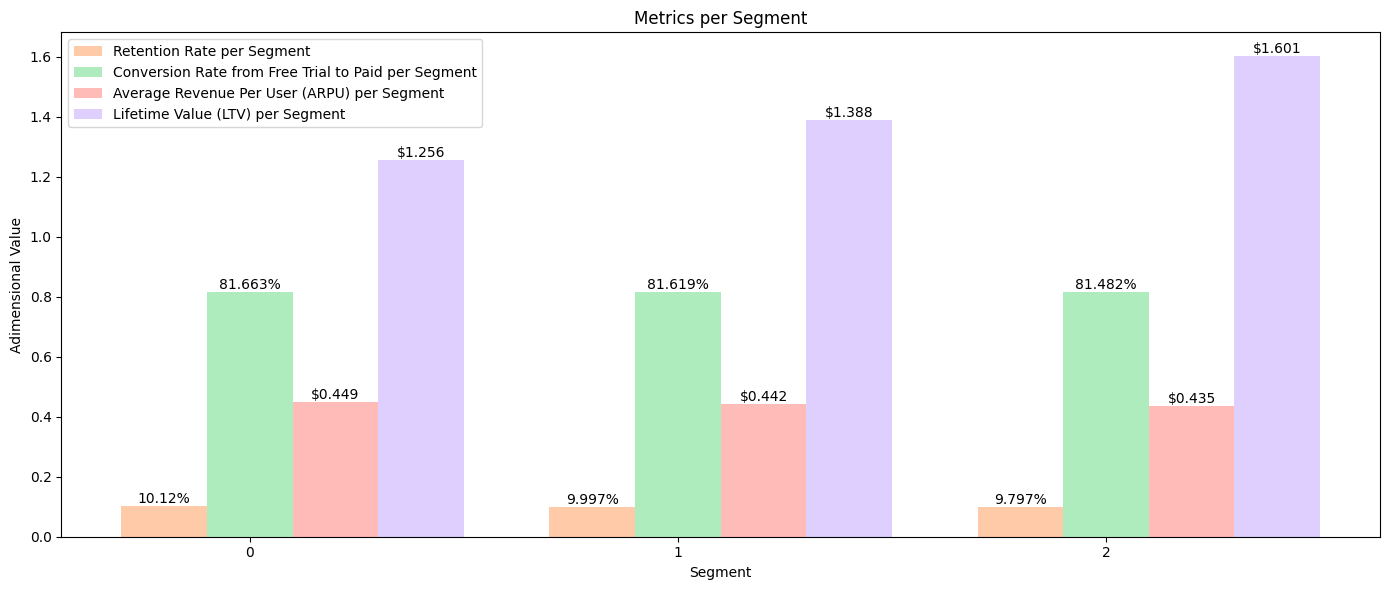

In [21]:
## Abstract plot

segments = retention_rate_by_segment.index
retention_rates = retention_rate_by_segment.values
conversion_rates = conversion_rate_by_segment.values
arpu = arpu_by_segment.values
ltv = list(ltv_by_segment.values())

plt.figure(figsize=(14, 6))

# Plotting Retention Rates
bar_width = 0.2
index = np.arange(len(segments))
plt.bar(index, retention_rates, width=bar_width, color=metric_palette[1], alpha=0.7, label='Retention Rate per Segment')
# Plotting Conversion Rates
plt.bar(index + bar_width, conversion_rates, width=bar_width, color=metric_palette[2], alpha=0.7, label='Conversion Rate from Free Trial to Paid per Segment')
# Plotting Average Revenue Per User (ARPU) 
plt.bar(index + 2 * bar_width, arpu, width=bar_width, color=metric_palette[3], alpha=0.7, label='Average Revenue Per User (ARPU) per Segment')
# Plotting Average Revenue Per User (ARPU) 
plt.bar(index + 3 * bar_width, ltv, width=bar_width, color=metric_palette[4], alpha=0.7, label='Lifetime Value (LTV) per Segment')
plt.xlabel('Segment')
plt.ylabel('Adimensional Value')
plt.title('Metrics per Segment')
plt.xticks(index + bar_width, segments)
plt.legend()

# Annotating bars with their values
for i in range(len(segments)):
    plt.text(index[i], retention_rates[i], f'{round(retention_rates[i]*100, 3)}%', ha='center', va='bottom')
    plt.text(index[i] + bar_width, conversion_rates[i], f'{round(conversion_rates[i]*100, 3)}%', ha='center', va='bottom')
    plt.text(index[i] + 2 * bar_width, arpu[i], f'${round(arpu[i], 3)}', ha='center', va='bottom')
    plt.text(index[i] + 3 * bar_width, ltv[i], f'${round(ltv[i], 3)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [22]:
ltv_by_segment 

{0: 1.2555936375404213, 1: 1.387622236693665, 2: 1.6007135735098137}

In [23]:
old_ltv = 1.2555936375404213
new_ltv = 1.6007135735098137

increment_revenue_percentage = ((new_ltv - old_ltv) / old_ltv) * 100
increment_revenue_percentage

27.486594838553565